In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from dataloader.depthloader import load_calib_cam_to_cam, disparity_loader
from utils.flowlib import read_flow, flow_to_image

In [4]:
## to be modified
data_path = '/ssd/kitti_scene/' # point to your KITTI data
pred_path = './precomputed/exp-kitti-train' # point to the predictions

In [5]:
# Sec 1. Scene flow results on KITTI validation set (Tab.1 in the paper)
d1_errs = [] # D1-err
d2_errs = [] # D2-err
fl_errs = [] # Fl-err
sf_err = [] # SF-err
for idnum in range(0,200,5):
    print('id: %d'%idnum)
    impath = '%s/training/image_2/%06d_10.png'%(data_path,idnum)
    framename = int(impath.split('/')[-1].split('_')[-2])

    # load ground-truth and masks for valid pixels
    flow_gt = read_flow('%s/training/flow_occ/%06d_10.png'%(data_path,framename)).astype(np.float32)
    disp0_gt = disparity_loader('%s/training/disp_occ_0/%06d_10.png'%(data_path,idnum))
    d1mask_gt = disp0_gt>0
    disp1_gt = disparity_loader('%s/training/disp_occ_1/%06d_10.png'%(data_path,idnum))
    d2mask_gt = disp1_gt>0
    shape = flow_gt.shape[:2]

    # load images and intrinsics
    im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
    im_nf = cv2.imread('%s/training/image_2/%06d_11.png'%(data_path,framename))
    ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(data_path,framename))
    K0 = ints['K_cam2']
    bl = ints['b20']-ints['b30']
    K1 = K0.copy()

    # load pre-computed results; tau is the motion-in-depth, and disp0 represents the first-frame disparity (inverse depth)
    flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
    tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))
    disp0 = disparity_loader('./precomputed/monodepth2/2015/%06d_10_disp.pfm'%(framename))
    # For lidar scene flowl, replace disp0 with sparse idar depth projection (inversed)
    # For stereo scene flow, replace disp0 with stereo disaprity
    
    # compute 2nd frame disp
    disp1 = disp0/tau
   
    # compute errors
    d1err = np.abs(disp0-disp0_gt)
    d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
    d1err[~d1mask_gt]=0
    d1_errs.append(d1err[d1mask_gt])
      
    d2err = np.abs(disp1-disp1_gt)
    d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
    d2err[~d2mask_gt]=0
    d2_errs.append(d2err[d2mask_gt])
    
    epe_map = np.sqrt(np.power(flow_gt[:,:,:2] - flow[:,:,:2],2).sum(-1))
    gt_mag_map = np.sqrt(np.power(flow_gt[:,:,:2],2).sum(-1))
    flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
    fl_errs.append( flerr[flow_gt[:,:,-1].astype(bool)]  )
    
    
    sf_err += list(np.logical_or(np.logical_or(flerr[flow_gt[:,:,-1].astype(bool)],d2err[flow_gt[:,:,-1].astype(bool)]),d1err[flow_gt[:,:,-1].astype(bool)]))

id: 0
id: 5


/home/gengshay/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/gengshay/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/home/gengshay/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


id: 10
id: 15
id: 20
id: 25
id: 30
id: 35
id: 40
id: 45
id: 50
id: 55
id: 60
id: 65
id: 70
id: 75
id: 80
id: 85
id: 90
id: 95
id: 100
id: 105
id: 110
id: 115
id: 120
id: 125
id: 130
id: 135
id: 140
id: 145
id: 150
id: 155
id: 160
id: 165
id: 170
id: 175
id: 180
id: 185
id: 190
id: 195


In [6]:
print('d1-err:%.2f'%(np.mean(np.concatenate(d1_errs))*100))
print('d2-err:%.2f'%(np.mean(np.concatenate(d2_errs))*100))
print('fl-err:%.2f'%(np.mean(np.concatenate(fl_errs))*100))
print('sf-err:%.2f'%(np.mean(sf_err)*100))

d1-err:14.65
d2-err:16.82
fl-err:6.00
sf-err:19.74


(-0.5, 1240.5, 375.5, -0.5)

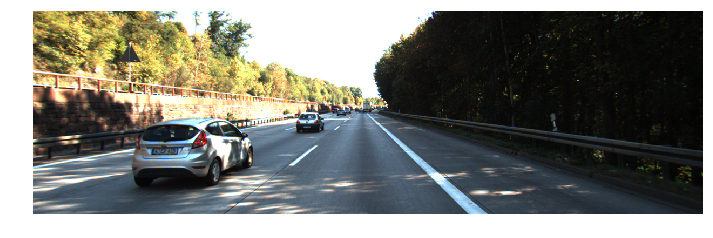

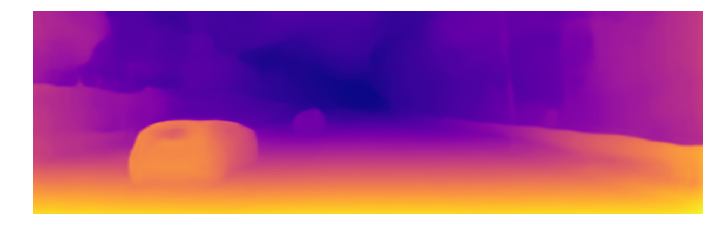

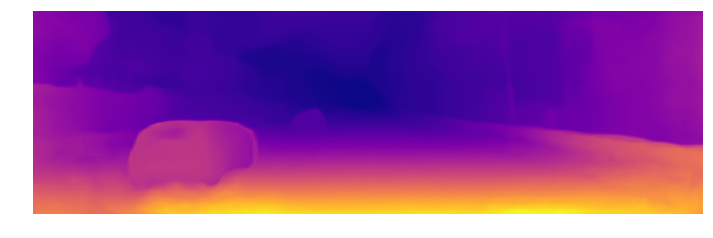

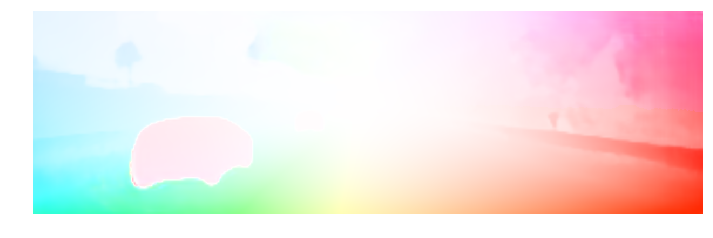

In [7]:
plt.figure(figsize=(12,4)); plt.imshow(im[:,:,::-1]); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(disp0,cmap='plasma'); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(disp1,cmap='plasma'); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(flow_to_image(flow),cmap='plasma'); plt.axis('off')

In [27]:
# Sec 2. Two-frame depth estimation  (Sec.4.5 in the paper)
# using frame 000195 as an example
# camera poses are computed by fitting essential matrix with RANSAC
framename=190
RT = np.loadtxt('precomputed/pose/%06d_10.txt'%framename)
R = RT[:3,:3]
T = RT[:3,-1]
flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))
im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
shape = tau.shape
ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(data_path,framename))
K0 = ints['K_cam2']
bl = ints['b20']-ints['b30']
K1 = K0.copy()

# depth from flow-triangulation
x0,y0=np.meshgrid(range(shape[1]),range(shape[0]))
x0=x0.astype(np.float32)
y0=y0.astype(np.float32)
x1=x0+flow[:,:,0]
y1=y0+flow[:,:,1]
hp0 = np.concatenate((x0[np.newaxis],y0[np.newaxis],np.ones(x1.shape)[np.newaxis]),0).reshape((3,-1))
hp1 = np.concatenate((x1[np.newaxis],y1[np.newaxis],np.ones(x1.shape)[np.newaxis]),0).reshape((3,-1))

P_pred = cv2.triangulatePoints(K0.dot(np.concatenate( (np.eye(3),np.zeros((3,1))), -1)), 
                         K1.dot(np.concatenate( (R.T,-R.T.dot(T[:,np.newaxis])), -1)), 
                         hp0[:2],hp1[:2])
P_pred = P_pred[:3]/P_pred[-1:]  
disp_flow = 1./P_pred[-1].reshape(shape)

In [28]:
# depth from up-to-scale flow
H01 = K0.dot(R).dot(np.linalg.inv(K1)) # remove the effect of camera rotation
hp1 = H01.dot(hp1)
# it can be proved that up to scale 3D flow = (ux, uy, uz)/d0(x,y) = K^{-1}(tau*p1-p0), tau = d1/d0
p3d = np.transpose(np.linalg.inv(K0).dot(tau.flatten()[np.newaxis]*hp1-hp0),[1,0])
disp_p3d = np.linalg.norm(p3d,2,1).reshape(shape) # forcing unit norm yields the disparity of the rigid pixels

(-0.5, 1240.5, 375.5, -0.5)

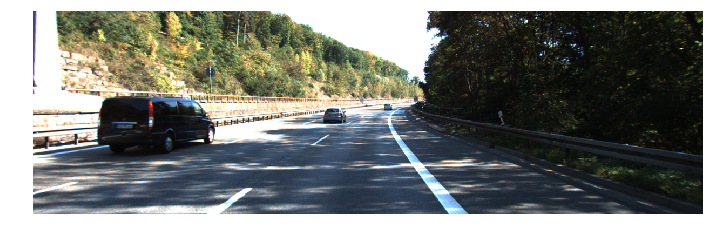

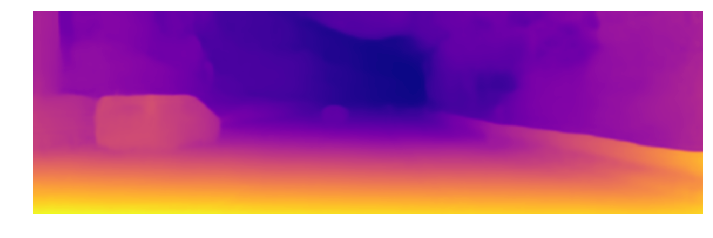

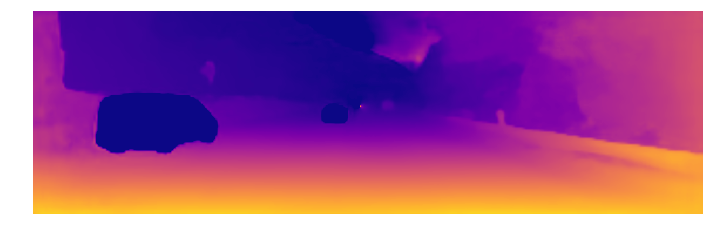

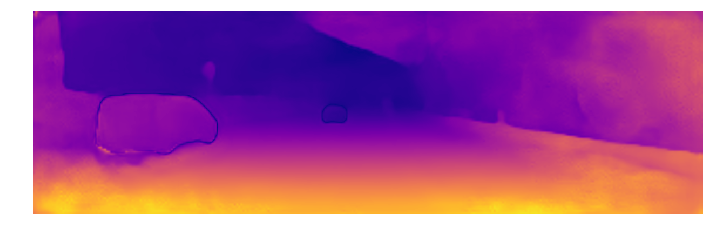

In [29]:
plt.figure(figsize=(12,4)); plt.imshow(im[:,:,::-1]); plt.axis('off')
# depth monodepth2
disp0 = disparity_loader('./precomputed/monodepth2/2015/%06d_10_disp.pfm'%(framename))
plt.figure(figsize=(12,4)); plt.imshow(disp0,cmap='plasma'); plt.axis('off')
# flow-triangulated depth
plt.figure(figsize=(12,4)); plt.imshow(disp_flow,vmax=0.4,vmin=0,cmap='plasma'); plt.axis('off')
# depth from up-to-scale flow
plt.figure(figsize=(12,4)); plt.imshow(disp_p3d,vmax=0.4,vmin=0,cmap='plasma'); plt.axis('off')